In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
from sklearn import datasets, linear_model, metrics
from coordination_numbers_calculation.utilities import cubic_harmonic, hanging_line
from matplotlib import cm
import warnings
warnings.filterwarnings("ignore")

### This notebook performs rotational averaging a method of quantifying the experimetal error in the dataset.  

In [4]:
# load the experimental data
df = pd.read_csv("data/experimental_data_with_gcn_features.csv")

In [5]:
# Load coordinates of the experimental data points on each of the 3 S4C surfaces
xyz_df= pd.read_csv("data/Coordinates_Cu.csv", index_col = False)
xyz_df = xyz_df.drop(columns ="Unnamed: 0")

In [6]:
# Laod the data of each sample to a separate dataframe 
df_100 = df[df["normal_miller_index"]==100]
df_111 = df[df["normal_miller_index"]==111]
df_110 = df[df["normal_miller_index"]==110]

In [7]:
# get the normalized miller for the 100 data
norm_miller_indices_100 = np.concatenate([df_100[df_100["molecule"]=="D-TA"]["h"].values.reshape(-1,1), 
df_100[df_100["molecule"]=="D-TA"]["k"].values.reshape(-1,1), 
df_100[df_100["molecule"]=="D-TA"]["l"].values.reshape(-1,1)], axis= 1)
xy_100_p = df_100[df_100["molecule"]=="D-TA"][["stereographic_projection_x", "stereographic_projection_y"]].values

In [8]:
# get the normalized miller for the 111 data
norm_miller_indices_111 = np.concatenate([df_111[df_111["molecule"]=="D-TA"]["h"].values.reshape(-1,1), 
df_111[df_111["molecule"]=="D-TA"]["k"].values.reshape(-1,1), 
df_111[df_111["molecule"]=="D-TA"]["l"].values.reshape(-1,1)], axis= 1)
xy_111_p = df_111[df_111["molecule"]=="D-TA"][["stereographic_projection_x", "stereographic_projection_y"]].values

In [9]:
# get the normalized miller for the 110 data
norm_miller_indices_110 = np.concatenate([df_110[df_110["molecule"]=="D-TA"]["h"].values.reshape(-1,1), 
df_110[df_110["molecule"]=="D-TA"]["k"].values.reshape(-1,1),
df_110[df_110["molecule"]=="D-TA"]["l"].values.reshape(-1,1)], axis =1)
xy_110_p = df_110[df_110["molecule"]=="D-TA"][["stereographic_projection_x", "stereographic_projection_y"]].values

In [10]:
# get the labels (D-TA half-time - L-TA half-time)
labels_100 = df_100[df_100["molecule"]=="D-TA"]["halftime(s)"].values.reshape(-1,1)- df_100[df_100["molecule"]=="L-TA"]["halftime(s)"].values.reshape(-1,1)
labels_110 = df_110[df_110["molecule"]=="D-TA"]["halftime(s)"].values.reshape(-1,1)- df_110[df_110["molecule"]=="L-TA"]["halftime(s)"].values.reshape(-1,1)
labels_111 = df_111[df_111["molecule"]=="D-TA"]["halftime(s)"].values.reshape(-1,1)- df_111[df_111["molecule"]=="L-TA"]["halftime(s)"].values.reshape(-1,1)

### Rotationally averaging the (100) sample
#### we do this by rotating the data by 45 degrees 8 times and calculating the average value of each set of the 8 symmetrically-equivalent surface orientations. When calculating the average value, we take care of the switiching of the sign of the magntiude of the halftime difference between the different quandrants of each the (100) sample. This avarage value is assignment to each of the symmetrically equivalent surface, achieving the rotational averaging. 

In [11]:
theta = np.pi/4
all_100_rotated_labels = []
for i in range(8):
    Rot_100 = np.array([np.cos(theta*i), -np.sin(theta*i), np.sin(theta*i), np.cos(theta*i)]).reshape(2,2)
    rotated_xy = xyz_df[["x", "y"]].values@Rot_100
    idx_list = []
    for i in range(0, len(xyz_df)):
        idx_list.append(np.argsort(np.sqrt((rotated_xy[i,:] - xyz_df[["x", "y"]].values)[:,0]**2 + (rotated_xy[i,:] - xyz_df[["x", "y"]].values)[:,1]**2))[0])
    rotated_100_labels = labels_100[idx_list]
    all_100_rotated_labels.append(rotated_100_labels)
    
all_100_rotated_labels = np.array(all_100_rotated_labels)

In [12]:
all_100_rotated_labels = all_100_rotated_labels.reshape(8,169)
mean_100_rotated_labels = (all_100_rotated_labels[0,:] - all_100_rotated_labels[1,:] +
                           all_100_rotated_labels[2,:] - all_100_rotated_labels[3,:] + 
                           all_100_rotated_labels[4,:] - all_100_rotated_labels[5,:] + 
                           all_100_rotated_labels[6,:] - all_100_rotated_labels[7,:])/8
rot_avg_100_labels = mean_100_rotated_labels.reshape(-1,1)

### Rotationally averaging the (110) sample
#### we do this by rotating the data by 90 degrees 4 times and averaging because the (110) data has 2 fold symmetry.

In [13]:
df_1 = pd.DataFrame({
    "x":xyz_df["x"].values.reshape(-1,),
    "y":xyz_df["y"].values.reshape(-1,),
    "halftime":labels_110.reshape(-1,),
})
# rotate by 90 degree (-y,x)
df_2 = pd.DataFrame({
    "x":-xyz_df["y"].values.reshape(-1,),
    "y":xyz_df["x"].values.reshape(-1,),
    "halftime":labels_110.reshape(-1,),
})
# rotate by 180 degree (-x,-y)
df_3 = pd.DataFrame({
    "x":-xyz_df["x"].values.reshape(-1,),
    "y":-xyz_df["y"].values.reshape(-1,),
    "halftime":labels_110.reshape(-1,),
})
# rotate by 270 degree (y,-x)
df_4 = pd.DataFrame({
    "x":xyz_df["y"].values.reshape(-1,),
    "y":-xyz_df["x"].values.reshape(-1,),
    "halftime":labels_110.reshape(-1,),
})

In [14]:
# merge the dataframes of the rotated data accounting for the floating point error 
## Apply rotational symmetry and reflection symmetry
final_110 = df_1.round(2).merge(df_2.round(2), on=["x", "y"], how = 'inner')
final_110 = final_110.merge(df_3.round(2), on=["x", "y"], how = 'inner')
final_110 = final_110.merge(df_4.round(2), on=["x", "y"], how = 'inner')
final_110.columns = ["x", "y", "halftime_0", "halftime_90", "halftime_180", "halftime_270"]
# The negative signs before the 90 deg and the 270 deg rotations apply the reflection symmetry
final_110["halftime"] = (final_110["halftime_0"] - final_110["halftime_90"] + final_110["halftime_180"] - final_110["halftime_270"])/4
rot_avg_110_labels = final_110["halftime"].values.reshape(-1,1)

### Rotationally averaging the (111) sample 
#### we do this by rotating the data by 60 degrees 6 times and averaging because the (111) data has 3-fold symmetry

In [15]:
theta = np.pi/3
all_111_rotated_labels = []
for i in range(6):
    Rot_111 = np.array([np.cos(theta*i), -np.sin(theta*i), np.sin(theta*i), np.cos(theta*i)]).reshape(2,2)
    rotated_xy = xyz_df[["x", "y"]].values@Rot_111
    idx_list = []
    for i in range(0, len(xyz_df)):
        idx_list.append(np.argsort(np.sqrt((rotated_xy[i,:] - xyz_df[["x", "y"]].values)[:,0]**2 + (rotated_xy[i,:] - xyz_df[["x", "y"]].values)[:,1]**2))[0])

    rotated_111_labels = labels_111[idx_list]
    all_111_rotated_labels.append(rotated_111_labels)
    
all_111_rotated_labels = np.array(all_111_rotated_labels)

In [16]:
rot_avg_111_labels = (all_111_rotated_labels[0,:].reshape(-1,) - all_111_rotated_labels[1,:].reshape(-1,)
           +all_111_rotated_labels[2,:].reshape(-1,) - all_111_rotated_labels[3,:].reshape(-1,)
           +all_111_rotated_labels[4,:].reshape(-1,) - all_111_rotated_labels[5,:].reshape(-1,))/6

rot_avg_111_labels = rot_avg_111_labels.reshape(-1,1)

In [19]:
sample_names = [(100), (110), (111)]
mean_values= [np.mean(np.abs(rot_avg_100_labels-labels_100)),
              np.mean(np.abs(rot_avg_110_labels-labels_110)),
              np.mean(np.abs(rot_avg_111_labels-labels_111))
             ]
std_values = [np.std(np.abs(rot_avg_100_labels-labels_100)),
             np.std(np.abs(rot_avg_110_labels-labels_110)),
             np.std(np.abs(rot_avg_111_labels-labels_111))]
# Create DataFrame
data = {
    'Sample Name': sample_names,
    'Mean experimental error(sec)': mean_values,
    'Standard Deviation(sec)': std_values
}

df = pd.DataFrame(data)
df

,Sample Name,Mean experimental error,Standard Deviation
0,100,160.091213,143.796947
1,110,224.609822,154.652392
2,111,58.169610,49.793014


### compute the average experimental error value across the 3 samples

In [21]:
all_experimental_labels = np.vstack([labels_100, labels_110, labels_111])
all_rot_avg_labels = np.vstack([rot_avg_100_labels, rot_avg_110_labels, rot_avg_111_labels])
print("mean experimental error:", np.mean(np.abs(all_rot_avg_labels-all_experimental_labels)), "sec")

mean experimental error: 147.6235485072321 sec


### Visualize the halftime difference data of the (100) sample before rotational averaging:

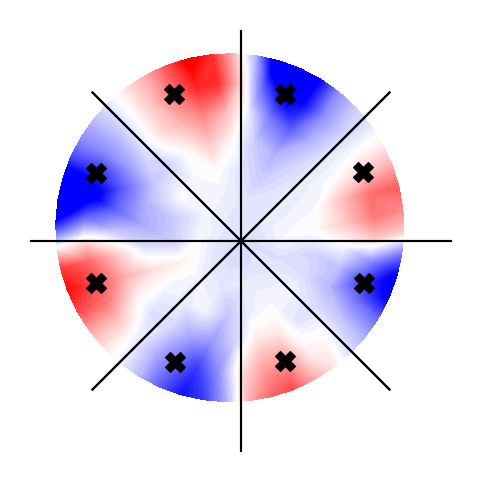

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))
norm = plt.Normalize(vmin=-800, vmax=800)
ax.tricontourf(xy_100_p[:,0], xy_100_p[:,1],labels_100.reshape(-1,),levels = 100,cmap='bwr', norm = norm)
plt.scatter(xy_100_p[120,0], xy_100_p[120,1],marker = "X", s = 200, c = "k")
plt.scatter(xy_100_p[115,0], xy_100_p[115,1],marker = "X", s = 200, c = "k")
plt.scatter(xy_100_p[110,0], xy_100_p[110,1],marker = "X", s = 200, c = "k")
plt.scatter(xy_100_p[105,0], xy_100_p[105,1],marker = "X", s = 200, c = "k")
plt.scatter(xy_100_p[100,0], xy_100_p[100,1],marker = "X", s = 200, c = "k")
plt.scatter(xy_100_p[95,0], xy_100_p[95,1],marker = "X", s = 200, c = "k")
plt.scatter(xy_100_p[90,0], xy_100_p[90,1],marker = "X", s = 200, c = "k")
plt.scatter(xy_100_p[85,0], xy_100_p[85,1],marker = "X", s = 200, c = "k")
# Define the angles (multiples of 45 degrees)
angles = np.arange(0, 360, 45)
# Define the radius of the circle
radius = 0.26
# Plot the lines at each angle
for angle in angles:
    # Convert angle to radians
    theta = np.radians(angle)
    # Calculate the endpoints of the line
    x1 = radius * np.cos(theta)
    y1 = radius * np.sin(theta)
    x2 = -radius * np.cos(theta)
    y2 = -radius * np.sin(theta)
    # Plot the line
    ax.plot([x1, x2], [y1, y2], color='k')
plt.gca().set_aspect('equal')
ax.axis('off')
plt.gca().set_aspect('equal')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
plt.show()

### After rotational averaging:

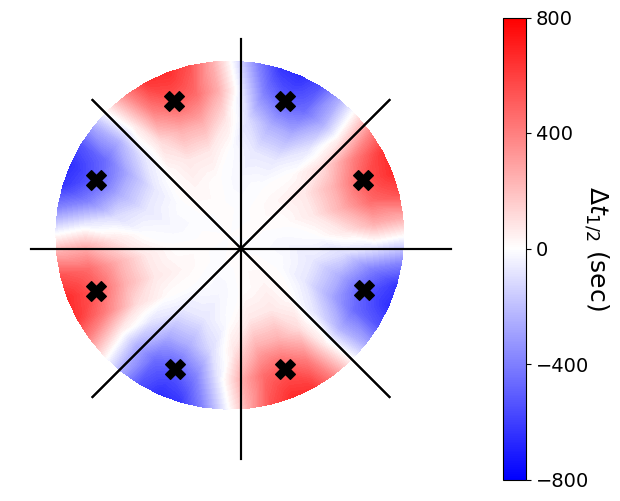

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))
norm = plt.Normalize(vmin=-800, vmax=800)
ax.tricontourf(xy_100_p[:,0], xy_100_p[:,1],rot_avg_100_labels.reshape(-1,),levels = 100,cmap='bwr', norm = norm)
plt.scatter(xy_100_p[120,0], xy_100_p[120,1],marker = "X", s = 200, c = "k")
plt.scatter(xy_100_p[115,0], xy_100_p[115,1],marker = "X", s = 200, c = "k")
plt.scatter(xy_100_p[110,0], xy_100_p[110,1],marker = "X", s = 200, c = "k")
plt.scatter(xy_100_p[105,0], xy_100_p[105,1],marker = "X", s = 200, c = "k")
plt.scatter(xy_100_p[100,0], xy_100_p[100,1],marker = "X", s = 200, c = "k")
plt.scatter(xy_100_p[95,0], xy_100_p[95,1],marker = "X", s = 200, c = "k")
plt.scatter(xy_100_p[90,0], xy_100_p[90,1],marker = "X", s = 200, c = "k")
plt.scatter(xy_100_p[85,0], xy_100_p[85,1],marker = "X", s = 200, c = "k")
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap="bwr"), ax = ax,orientation="vertical")
cbar.set_ticks(np.linspace(-800, 800, 5))
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(14)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel("$\Delta{t_{1/2}}$ (sec)", fontsize= 18,rotation=270)
# Define the radius of the circle
radius = 0.26
# Plot the lines at each angle
for angle in angles:
    # Convert angle to radians
    theta = np.radians(angle)
    # Calculate the endpoints of the line
    x1 = radius * np.cos(theta)
    y1 = radius * np.sin(theta)
    x2 = -radius * np.cos(theta)
    y2 = -radius * np.sin(theta)
    # Plot the line
    ax.plot([x1, x2], [y1, y2], color='k')
ax.axis('off')
plt.gca().set_aspect('equal')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
plt.show()

### Result of doing rotational averaging on the 3 S4C samples:

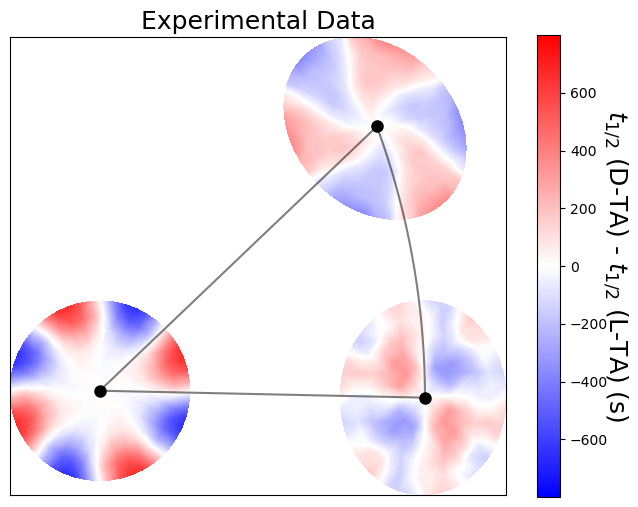

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))
norm = plt.Normalize(vmin=-800, vmax=800)
ax.tricontourf(xy_100_p[:,0], xy_100_p[:,1],rot_avg_100_labels.reshape(-1,),levels = 100,cmap='bwr', norm = norm)
ax.tricontourf(xy_110_p[:,0], xy_110_p[:,1],rot_avg_110_labels.reshape(-1,),levels = 100,cmap='bwr', norm = norm)
ax.tricontourf(xy_111_p[:,0], xy_111_p[:,1],rot_avg_111_labels.reshape(-1,),levels = 100,cmap='bwr', norm = norm)

cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap="bwr"), ax = ax,orientation="vertical")
cbar.set_ticks(np.linspace(-600, 600, 7))
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel("$t_{1/2}$ (D-TA) - $t_{1/2}$ (L-TA) (s)", fontsize= 18,rotation=270)
plt.plot(xy_100_p[0,0], xy_100_p[0,1], 'k', marker="o", markersize=8, label = "(100)")
plt.plot(xy_110_p[0,0], xy_110_p[0,1], 'k', marker="o", markersize=8, label = "(110)")
plt.plot(xy_111_p[0,0], xy_111_p[0,1], 'k', marker="o", markersize=8, label = "(111)")

#Draw the stereograhic triangle
x_values_1 = xy_100_p[0,0], xy_110_p[0,0]
y_values_1 =  xy_100_p[0,1], xy_110_p[0,1]
ax.plot(x_values_1, y_values_1, 'k', linestyle="-", alpha = 0.5)
x_values_2 = xy_100_p[0,0], xy_111_p[0,0]
y_values_2 =  xy_100_p[0,1], xy_111_p[0,1]
ax.plot(x_values_2, y_values_2, 'k', linestyle="-", alpha = 0.5)
point1 = [xy_111_p[0,1], xy_111_p[0,0],]
point2 = [xy_110_p[0,1], xy_110_p[0,0], ]
y,x = hanging_line(point1, point2)
ax.plot(x,y,'k', linestyle="-", alpha = 0.5)
ax.set_title("Experimental Data", fontsize = 18)

plt.gca().set_aspect('equal')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off


plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
plt.show()